In [1]:
# Базовый импорт
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Импорт моделей
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Импорт метрик и селекторов
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

# Импорт препроцессоров
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print(f"✅ Dataset loaded successfully!")
print(f"   📈 Dataset shape: {df.shape}")
print(f"   📋 Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

null_counts = df.isnull().sum()
duplicate_counts = df.duplicated().sum()

print(f"   🔍 Missing values: {null_counts.sum()}")
print(f"   🔄 Duplicate records: {duplicate_counts}")
print(f"   📊 Data types distribution:")
print(f"      - Numeric: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"      - Object: {df.select_dtypes(include=['object']).shape[1]}")

✅ Dataset loaded successfully!
   📈 Dataset shape: (7043, 21)
   📋 Memory usage: 6984.66 KB
   🔍 Missing values: 0
   🔄 Duplicate records: 0
   📊 Data types distribution:
      - Numeric: 3
      - Object: 18


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df[['TotalCharges', 'MonthlyCharges', 'tenure']].describe()

,TotalCharges,MonthlyCharges,tenure
count,7032.000000,7043.000000,7043.000000
mean,2283.300441,64.761692,32.371149
std,2266.771362,30.090047,24.559481
min,18.800000,18.250000,0.000000
25%,401.450000,35.500000,9.000000
50%,1397.475000,70.350000,29.000000
75%,3794.737500,89.850000,55.000000
max,8684.800000,118.750000,72.000000


In [6]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
result = df.isnull().sum() / len(df) * 100
result[result > 0]

TotalCharges    0.156183
dtype: float64

In [7]:
pd.set_option('future.no_silent_downcasting', True)

df = df.drop('customerID', axis=1)

# old
#for col in ['Partner', 'Dependents', 'PaperlessBilling']:
#    df[col] = df[col].map({'Yes': 1, 'No': 0})

# new
binary_features = ['Partner', 'Dependents', 'PaperlessBilling']
df[binary_features] = df[binary_features].replace({'Yes': 1, 'No': 0}).astype(int)

services_to_count = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies'
] 

df['ServicesCount'] = 0
df['ServicesCount'] += (df['PhoneService'] == 'Yes').astype(int)
df['ServicesCount'] += (df['MultipleLines'] == 'Yes').astype(int)
df['ServicesCount'] += (df['InternetService'] != 'No').astype(int)

# old
#for col in services_to_count:
#    df['ServicesCount'] += (df[col] == 'Yes').astype(int)

# new
df['ServicesCount'] += (df[services_to_count] == 'Yes').sum(axis=1)

df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)

#df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
#df['TotalCharges'] = df['TotalCharges'].apply(float)
#df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [8]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
ServicesCount       0
dtype: int64

# Разделю признаки на несколько групп
1. Сервисы, которыми пользуются клиенты:
    - PhoneService
    - MultipleLines
    - InternetService
    - OnlineSecurity
    - OnlineBackup
    - DeviceProtection
    - TechSupport
    - StreamingTV
    - StreamingMovies
2. Демографические признаки:
    - gender
    - SeniorCitizen
    - Partner
    - Dependents
3. Информация об аккаунте клиента:
    - tenure (сколько месяцев клиент пользуется продуктом)
    - Contract
    - PaperlessBilling
    - PaymentMethod
    - MonthlyCharges
    - TotalCharges

Целевая переменная: Churn

# Выдвину некоторые гипотезы
1. Пол и возраст не имеют значимого влияния на отток клиентов. (Нулевая гипотеза)
2. Чем больше (по времени) клиент пользуется услугами сервиса, тем реже уходит.
3. Наличие партнёра или иждивенца влияет на вероятность ухода клиент.
4. Срок контракта прямым образом влияет на уход клиента, месячный - выше шанс ухода, годовой - ниже.
5. Чем меньше услуг подключено, тем выше вероятность ухода клиента.
6. Большие траты в месяц прямым образом могут повлиять на уход клиента, чем выше, тем больше шанс ухода.
7. Клиенты с безбумажным биллингом (PaperlessBilling = Yes) уходят реже, чем клиенты с бумажными счетами.
8. Клиенты с автоматической оплатой (Bank transfer или Credit card) уходят реже, чем клиенты с электронными или почтовыми чеками.

# Предварительный анализ

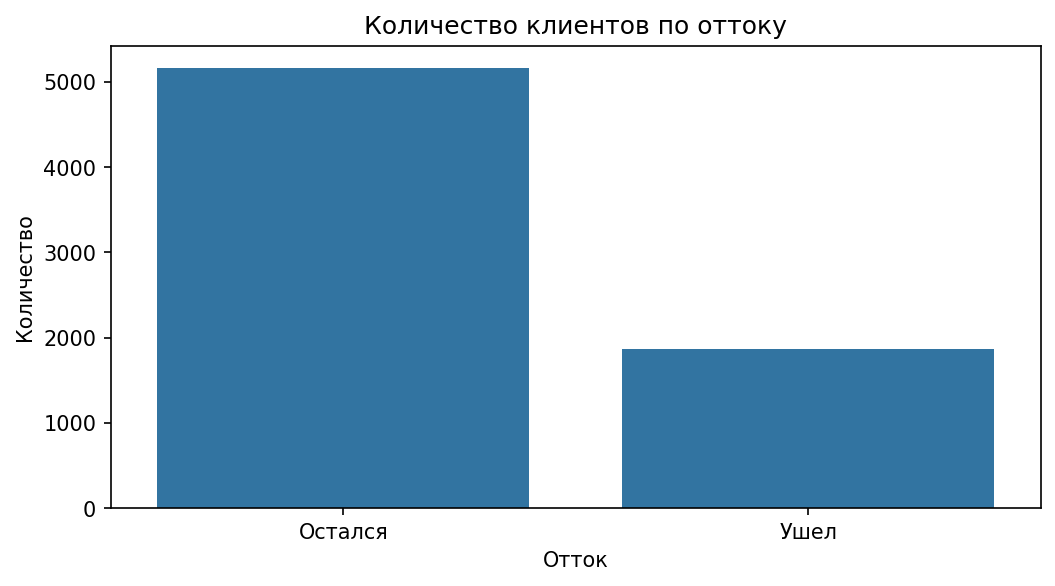

In [9]:
plt.figure(figsize=(8, 4), dpi=150)
sns.countplot(data=df, x='Churn')
plt.title('Количество клиентов по оттоку')
plt.xticks([0, 1], ['Остался', 'Ушел'])
plt.ylabel('Количество')
plt.xlabel('Отток');

Выводы по графику:
1. Классы несбалансированны, нельза будет точно оценивать модель по точности (метрика accuracy).
2. Понадобится бороться с дисбалансом классов путем указания class_weights='balanced' (если у модели есть такой параметр).

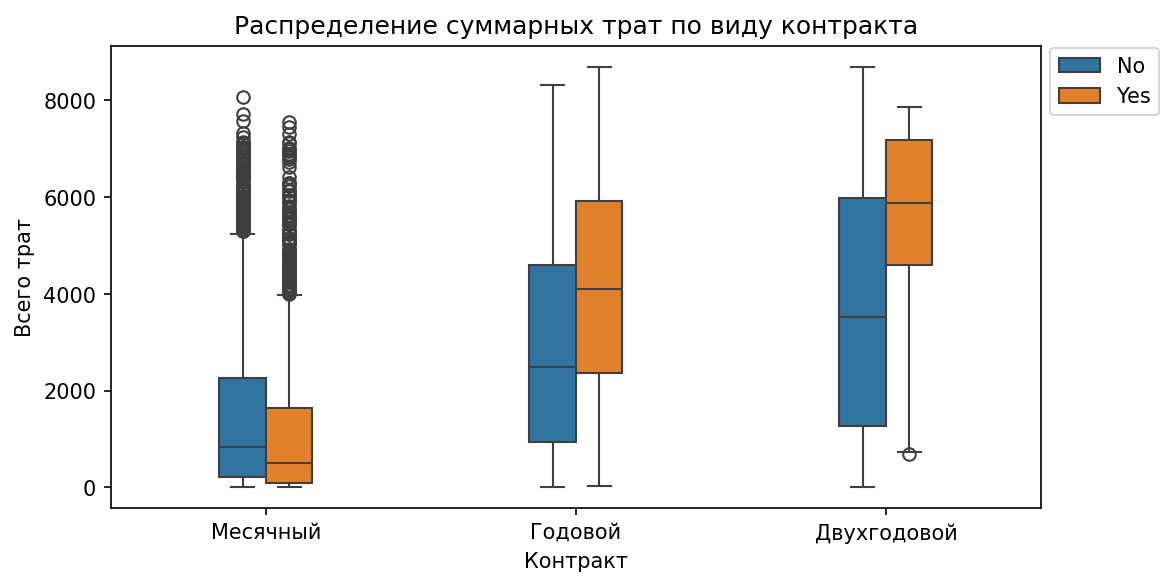

In [10]:
plt.figure(figsize=(8, 4), dpi=150)
sns.boxplot(data=df, x='Contract', y='TotalCharges', hue='Churn', width=0.3)
plt.title('Распределение суммарных трат по виду контракта')
plt.ylabel('Всего трат')
plt.xlabel('Контракт')
plt.xticks([0, 1, 2], ['Месячный', 'Годовой', 'Двухгодовой']);
plt.legend(loc=(1.01, 0.85)); # title='Отток клиента', labels=['Остался', 'Ушел'],

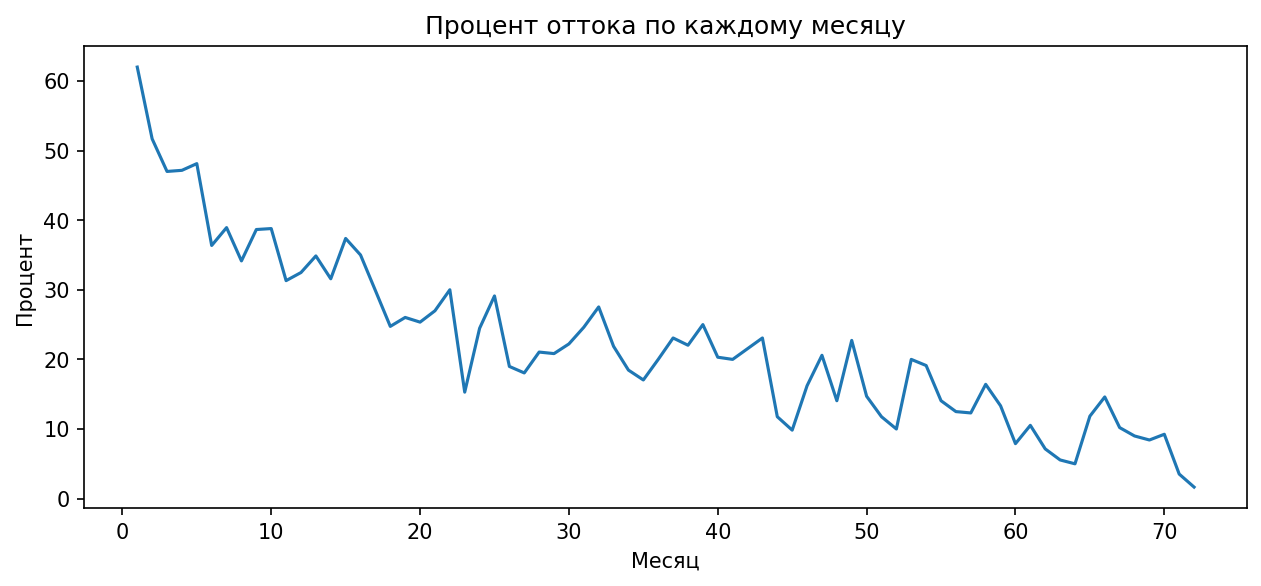

In [11]:
plt.figure(figsize=(10, 4), dpi=150)
pct_list = []
for n in range(1, 73):
    percent = len(df[(df['tenure'] == n) & (df['Churn'] == 'Yes')]) / len(df[df['tenure'] == n]) * 100
    pct_list.append(percent)
plt.plot(range(1, 73), pct_list);
plt.title('Процент оттока по каждому месяцу')
plt.xlabel('Месяц')
plt.ylabel('Процент');

Выводы по графику:
1. Процент оттока падает с увеличением стажа клиента.

# Гипотеза 1
## Пол и возраст не имеют значимого влияния на отток клиентов. (Нулевая гипотеза)

In [12]:
df['gender'].value_counts()

gender
Male      3549
Female    3483
Name: count, dtype: int64

In [13]:
df['gender'].value_counts() / df['gender'].count() * 100

gender
Male      50.469283
Female    49.530717
Name: count, dtype: float64

In [14]:
gender_churn_pct = df.groupby(['gender', 'Churn'])['Churn'].count().unstack().apply(lambda x: x/x.sum()*100, axis=1)

In [15]:
gender_churn_pct

Churn,No,Yes
gender,,
Female,73.040482,26.959518
Male,73.795435,26.204565


In [16]:
df_gender_long = gender_churn_pct.reset_index().melt(id_vars='gender', 
                                              value_vars=['No','Yes'],
                                              var_name='Churn',
                                              value_name='Percentage')

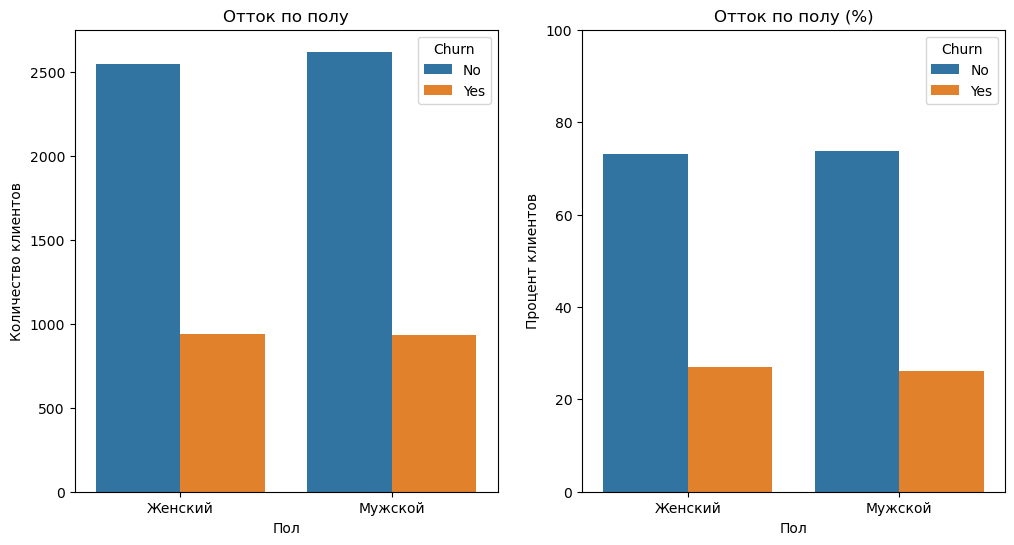

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df, x='gender', hue='Churn', ax=axes[0])
axes[0].set_title('Отток по полу')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xlabel('Пол')
axes[0].set_xticks([0, 1], ['Женский', 'Мужской']);

sns.barplot(data=df_gender_long, x='gender', y='Percentage', hue='Churn', ax=axes[1])
axes[1].set_ylabel('Процент клиентов')
axes[1].set_xlabel('Пол')
axes[1].set_title('Отток по полу (%)')
axes[1].set_xticks([0, 1], ['Женский', 'Мужской']);
axes[1].set_ylim(0, 100);

Выводы по графику:
1) Количество мужчин и женщин примерно одинаково. По графикам видно, что доля ушедших и оставшихся клиентов примерно одинаковая в обеих группах, что говорит о том, что пол, вероятно, не сильно влияет на отток.

In [18]:
df['SeniorCitizen'].value_counts()

SeniorCitizen
0    5890
1    1142
Name: count, dtype: int64

Пожилых клиентов значительно меньше, чем молодых. При визуализации на countplot нужно учитывать разный размер групп, так как абсолютные значения будут сильно отличаться.

In [19]:
age_churn_pct = df.groupby(['SeniorCitizen', 'Churn'])['Churn'].count().unstack().apply(lambda x: x/x.sum()*100, axis=1)

In [20]:
age_churn_pct

Churn,No,Yes
SeniorCitizen,,
0,76.349745,23.650255
1,58.318739,41.681261


In [21]:
df_age_group_long = age_churn_pct.reset_index().melt(id_vars='SeniorCitizen',
                                                     value_vars=['No', 'Yes'],
                                                     var_name='Churn',
                                                     value_name='Percentage')

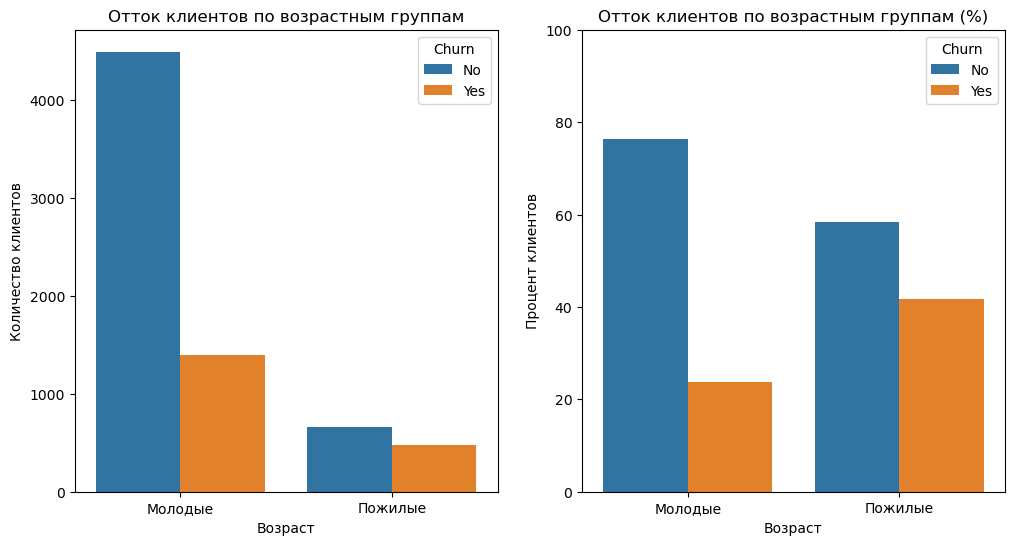

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df, x='SeniorCitizen', hue='Churn', ax=axes[0])
axes[0].set_title('Отток клиентов по возрастным группам')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xlabel('Возраст')
axes[0].set_xticks([0, 1], ['Молодые', 'Пожилые']);

sns.barplot(data=df_age_group_long, x='SeniorCitizen', y='Percentage', hue='Churn', ax=axes[1])
axes[1].set_title('Отток клиентов по возрастным группам (%)')
axes[1].set_ylabel('Процент клиентов')
axes[1].set_xlabel('Возраст')
axes[1].set_xticks([0, 1], ['Молодые', 'Пожилые'])
axes[1].set_ylim(0, 100);

Выводы по графику:
1. Доля ушедших клиентов (Churn = Yes) среди пожилых (SeniorCitizen = 1) выше (≈42%), чем среди молодых (SeniorCitizen = 0) (≈24%).
2. Доля оставшихся клиентов (Churn = No) среди молодых выше (≈76%) по сравнению с пожилыми (≈58%).
    Следовательно, возраст может быть фактором, влияющим на уход клиента, так как наблюдается заметная разница между группами.

## Выводы по гипотезе 1
1. Проанализировав количество и процент клиентов по полу, а также распределение оттока (Churn No/Yes), можно сделать вывод, что пол, скорее всего, не оказывает значимого влияния на отток клиентов.
2. Большинство клиентов - молодые (5901), пожилых значительно меньше (1142). При сравнении долей оставшихся и ушедших видно, что доля ушедших среди пожилых (≈42%) выше, чем среди молодых (≈24%), а доля оставшихся молодых (≈76%) выше, чем пожилых (≈58%). Эти данные позволяют предположить, что возраст может влиять на отток клиентов.

# Гипотеза 2
## Чем больше (по времени) клиент пользуется услугами сервиса, тем реже уходит.

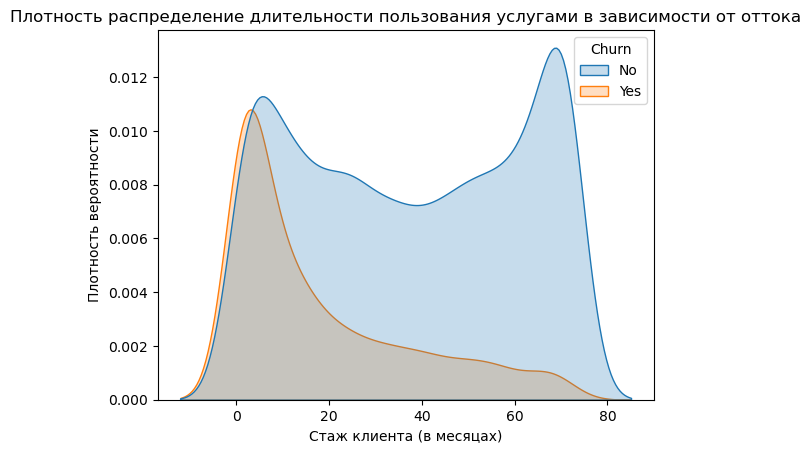

In [23]:
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True)
plt.title('Плотность распределение длительности пользования услугами в зависимости от оттока')
plt.xlabel('Стаж клиента (в месяцах)')
plt.ylabel('Плотность вероятности');

In [24]:
pd.concat([df[df['Churn'] == 'No']['tenure'].describe(), \
            df[df['Churn'] == 'Yes']['tenure'].describe()], axis=1, ignore_index=True).transpose()

,count,mean,std,min,25%,50%,75%,max
0,5163.0,37.650010,24.076940,1.0,15.0,38.0,61.0,72.0
1,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


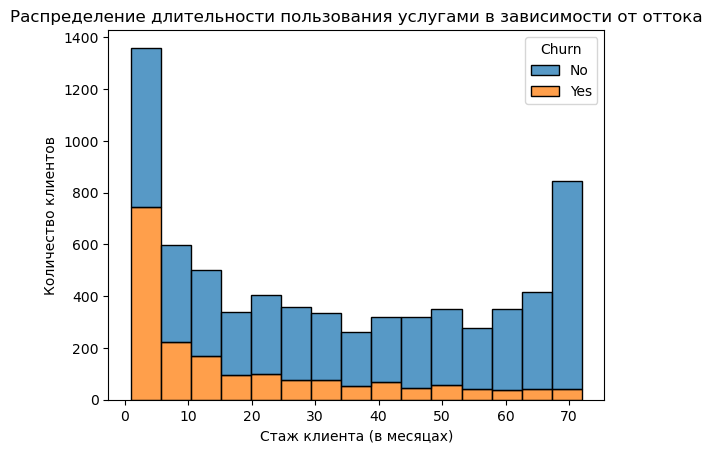

In [25]:
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack')
plt.title('Распределение длительности пользования услугами в зависимости от оттока')
plt.xlabel('Стаж клиента (в месяцах)')
plt.ylabel('Количество клиентов');

Выводы по графику:
1) Группа ушедших клиентов резко преобладает среди тех, кто пользуется услугами менее 10 месяцев (особенно это видно в первые 5 месяцев). Это признак "раннего оттока", который свидетельствует о первоначальной неудовлетворенности продуктом или плохой адаптации.
2) Наибольшее количество оставшихся клиентов сосредоточено среди тех, кто пользуется продуктом дольше всего (более 60 месяцев). Столбец в диапазоне 60−70+ является самым высоким после первого, и при этом в нем самый низкий относительный уровень оттока (оранжевый цвет занимает наименьшую долю). Это говорит о высокой лояльности и стабильности "старых" клиентов.
3) Начиная примерно с 15 месяцев и до 65 месяцев, общая высота столбцов (общее количество клиентов) остается относительно постоянной. В этом диапазоне клиенты находятся в состоянии стабильной лояльности - они не уходят массово (низкий оранжевый сегмент), но и общее их число растет не так быстро, как в конце.

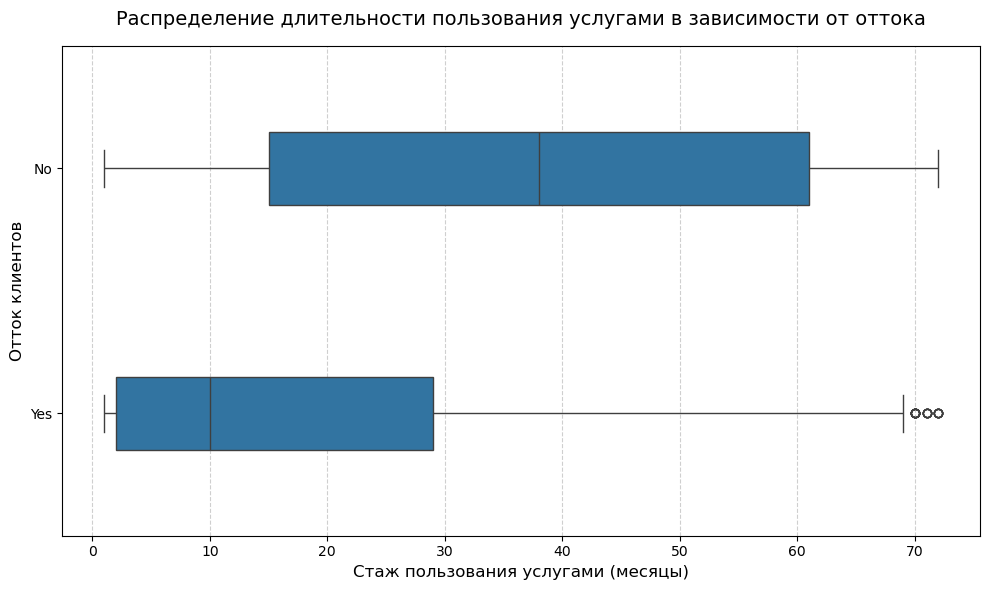

In [26]:
plt.figure(figsize=(10, 6), dpi=100)
sns.boxplot(data=df, x='tenure', y='Churn', width=0.3);
plt.title('Распределение длительности пользования услугами в зависимости от оттока', fontsize=14, pad=15)
plt.xlabel('Стаж пользования услугами (месяцы)', fontsize=12)
plt.ylabel('Отток клиентов', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout();

#plt.axhline(y=np.quantile(a=df[df['Churn'] == 'No']['tenure'],q=0.25), linestyle='--', alpha=0.6)
#plt.axhline(y=np.quantile(a=df[df['Churn'] == 'No']['tenure'],q=0.75), linestyle='--', alpha=0.6)
#plt.axhline(y=np.quantile(a=df[df['Churn'] == 'Yes']['tenure'],q=0.25), linestyle='--', alpha=0.6)
#plt.axhline(y=np.quantile(a=df[df['Churn'] == 'Yes']['tenure'],q=0.75), linestyle='--', alpha=0.6);

Выводы по графику:
1) Медиана у группы оставшихся клиентов (≈38 месяцев) значительно больше, чем у ушедших (≈10 месяцев). Это сильное подтверждение того, что длительная продолжительность пользования услугами прямо связана с низкой вероятностью оттока. Чем дольше клиент пользуется услугами, тем реже уходит.
2) Время пользование услугой сильно варьируется у оставшихся клиентов, тогда как у ушедших клиентов меньше вариативности. Это говорит нам о том, что клиенты уходят, как правило, в начале пользования услугой (0-30 месяцев).
3) Группа ушедших клиентов (Churn = Yes) преобладает среди тех, кто пользуется улугами в основном от 3 до 30 месяцев (50% от всех ушедших), тогда как оставшиеся клиенты (Churn = No) в основном пользуются услугами от 15 до 65 месяцев (50% от всех оставшихся). 75% всех ушедших клиентов пользуются услугами менее 30 месяцев, то есть 0−30 месяцев - зона самого высокого риска оттока.
4) В группе ушедших можно заметить выбросы, которые показывают самых лояльных клиентов, которые пользовались услугами более 6 лет, но все равно ушли. Эти случаи могут быть связаны с другими механизмами оттока.

### Выводы по гипотезе 2
1. Критическая зона риска: 75% всех ушедших клиентов уходят в течение первых 30 месяцев пользования услугами, что подчеркивается низкой медианой ушедших (≈10 месяцев) по сравнению с оставшимися (≈38 месяцев).
2. Зона стабильности: Клиенты, преодолевшие 30-месячный порог, демонстрируют высокую стабильность. Вероятность оттока минимальна для группы, пользующейся услугами более 60-70 месяцев, что указывает на формирование ядра лояльности.

Таким образом, можно сделать вывод: клиенты чаще всего уходят в первые 0–30 месяцев после начала обслуживания, а длительное использование услуг значительно снижает вероятность оттока. Гипотеза подтверждена.

# Гипотеза 3
## Наличие партнёра или иждивенца влияет на вероятность ухода клиент.

In [27]:
df['Partner'].value_counts()

Partner
0    3639
1    3393
Name: count, dtype: int64

In [28]:
df['Partner'].value_counts() / df['Partner'].count() * 100

Partner
0    51.749147
1    48.250853
Name: count, dtype: float64

Группы хорошо сбалансированны (51.7% / 48.3%), поэтому можно сравнить их по признаку Churn.

In [29]:
partner_churn_pct = df.groupby(['Partner', 'Churn'])['Churn'].count().unstack().apply(lambda x: x/x.sum()*100, axis=1)

In [30]:
partner_churn_pct

Churn,No,Yes
Partner,,
0,67.023908,32.976092
1,80.282935,19.717065


In [31]:
df_partner_long = partner_churn_pct.reset_index().melt(id_vars='Partner', 
                                              value_vars=['No', 'Yes'],
                                              var_name='Churn',
                                              value_name='Percentage')

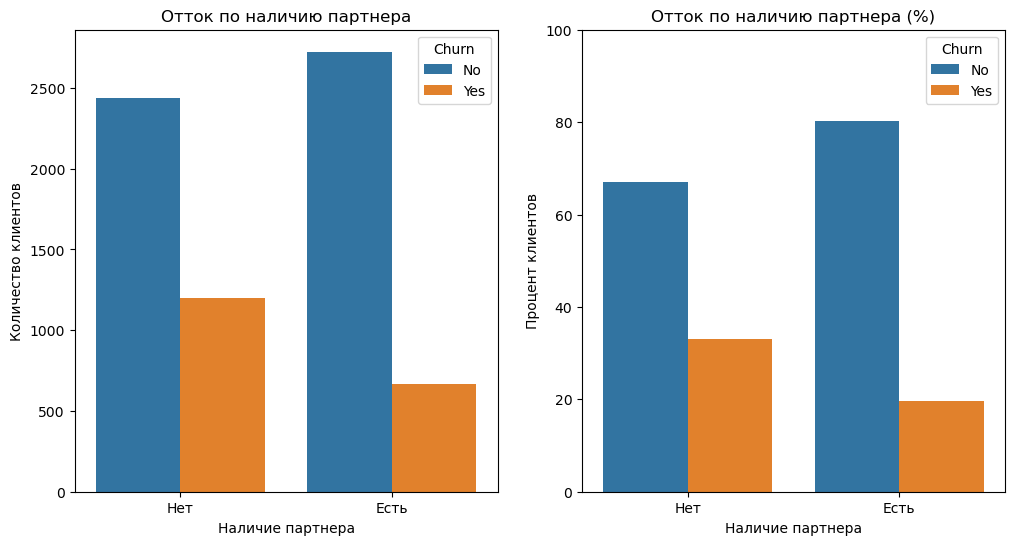

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df, x='Partner', hue='Churn', ax=axes[0])
axes[0].set_title('Отток по наличию партнера')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xticks([0, 1], ['Нет', 'Есть'])
axes[0].set_xlabel('Наличие партнера');

sns.barplot(data=df_partner_long, x='Partner', y='Percentage', hue='Churn', ax=axes[1])
axes[1].set_xticks([0, 1], ['Нет', 'Есть'])
axes[1].set_ylabel('Процент клиентов')
axes[1].set_xlabel('Наличие партнера')
axes[1].set_title('Отток по наличию партнера (%)')
axes[1].set_ylim(0, 100);

Выводы по графику:
1) Отток клиентов без партнера ('Нет' - ≈33%) выше, чем отток клиентов с партнером ('Есть' - ≈20%), что говорит о том, что отсутствие партнера является фактором высокого риска оттока. И наоборот, наличие партнера является фактором для удержания клиена.

In [33]:
df['Dependents'].value_counts()

Dependents
0    4933
1    2099
Name: count, dtype: int64

In [34]:
df['Dependents'].value_counts() / df['Dependents'].count() * 100

Dependents
0    70.150739
1    29.849261
Name: count, dtype: float64

Наблюдается сильный дисбаланс групп, абсолютные значения не будут отражать достоверные данные.

In [35]:
dependent_churn_pct = df.groupby(['Dependents', 'Churn'])['Churn'].count().unstack().apply(lambda x: x/x.sum()*100, axis=1)

In [36]:
dependent_churn_pct

Churn,No,Yes
Dependents,,
0,68.720860,31.279140
1,84.468795,15.531205


In [37]:
df_partner_long = dependent_churn_pct.reset_index().melt(id_vars='Dependents', 
                                              value_vars=['No','Yes'],
                                              var_name='Churn',
                                              value_name='Percentage')

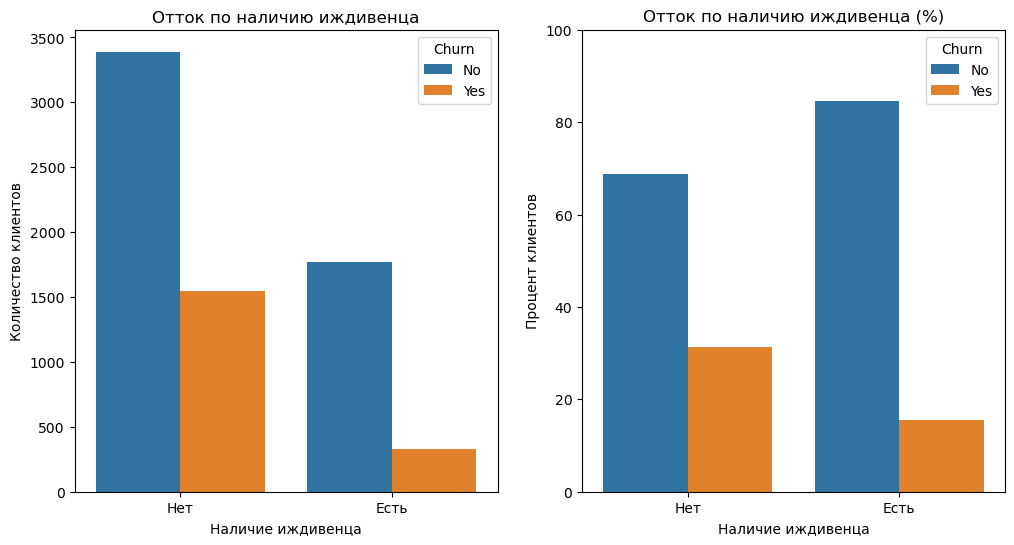

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df, x='Dependents', hue='Churn', ax=axes[0])
axes[0].set_title('Отток по наличию иждивенца')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xticks([0, 1], ['Нет', 'Есть'])
axes[0].set_xlabel('Наличие иждивенца');

sns.barplot(data=df_partner_long, x='Dependents', y='Percentage', hue='Churn', ax=axes[1])
axes[1].set_xticks([0, 1], ['Нет', 'Есть'])
axes[1].set_ylabel('Процент клиентов')
axes[1].set_xlabel('Наличие иждивенца')
axes[1].set_title('Отток по наличию иждивенца (%)')
axes[1].set_ylim(0, 100);

Выводы по графику:
1) Отсутствие иждивенцев удерживает ≈69% клиентов, тогда как наличие удерживает ≈85% клиентов.
2) Отсутствие иждивенцев увеличивает вероятность оттока вдвое (31%/15%≈2.07 раза).

### Выводы по гипотезе 3
1) Наличие партнера является сильным фактором удержания клиента. Риск оттока для клиентов без партнера (≈33%) в 1.65 раза выше, чем для клиентов с партнером (≈20%).
2) Клиенты с иждивенцами (≈15% оттока) более чем в два раза реже уходят по сравнению с клиентами без них (≈31% оттока). Это указывает на то, что семейные клиенты гораздо более привержены сервису.

Гипотеза о влиянии партнера или иждивенца на вероятность ухода клиента - подтверждена. Наличие парнера и/или иждивенца помогает удерживать клиентов.

# Гипотеза 4
## Срок контракта прямым образом влияет на уход клиента, месячный - выше шанс ухода, годовой - ниже.

In [39]:
contract_churn_pct = df.groupby(['Contract', 'Churn'])['Churn'].count().unstack().apply(lambda x: x/x.sum()*100, axis=1)

In [40]:
contract_churn_pct

Churn,No,Yes
Contract,,
Month-to-month,57.290323,42.709677
One year,88.722826,11.277174
Two year,97.151335,2.848665


In [41]:
df_contract_long = contract_churn_pct.reset_index().melt(id_vars='Contract', 
                                              value_vars=['No', 'Yes'],
                                              var_name='Churn',
                                              value_name='Percentage')

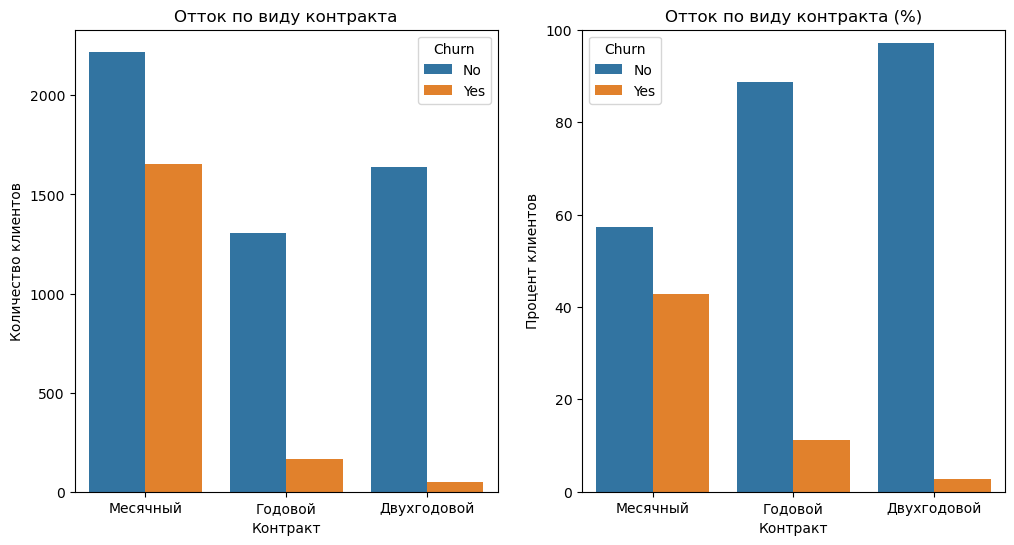

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df, x='Contract', hue='Churn', ax=axes[0])
axes[0].set_title('Отток по виду контракта')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xticks([0, 1, 2], ['Месячный', 'Годовой', 'Двухгодовой'])
axes[0].set_xlabel('Контракт');

sns.barplot(data=df_contract_long, x='Contract', y='Percentage', hue='Churn', ax=axes[1])
axes[1].set_xticks([0, 1, 2], ['Месячный', 'Годовой', 'Двухгодовой'])
axes[1].set_ylabel('Процент клиентов')
axes[1].set_xlabel('Контракт')
axes[1].set_title('Отток по виду контракта (%)')
axes[1].set_ylim(0, 100);

Выводы по графику:
1) Клиенты, пользующиеся месячным контрактом, уходят примерно так же часто, как те, кто остается (≈43% отток, ≈57% удержание).
2) Годовой и двухгодовой контракты являются сильнейшим фактором удержания клиентов. При годовом контракте ≈11% - отток, а при двухгодовом - ≈3%.

### Выводы по гипотезе 4
1) Месячный контракт - зона максимального риска оттока, так как уходят ≈43%, а остаются ≈57%.
2) Годовой и двухгодовой контракты - самые сильные факторы влияния на удержание клиентов. При годовом контракте ≈11% - отток, а при двухгодовом - ≈3%.

Гипотеза 4: Срок контракта прямым образом влияет на уход клиента, месячный - выше шанс ухода, годовой - ниже. - Подтверждена.

# Гипотеза 5
## Чем меньше услуг подключено, тем выше вероятность ухода клиента.

In [43]:
df['Churn'].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

In [44]:
df['Churn'].value_counts() / df['Churn'].count() * 100

Churn
No     73.421502
Yes    26.578498
Name: count, dtype: float64

Нельзя напрямую сравнить, так как группы не сбалансированны.

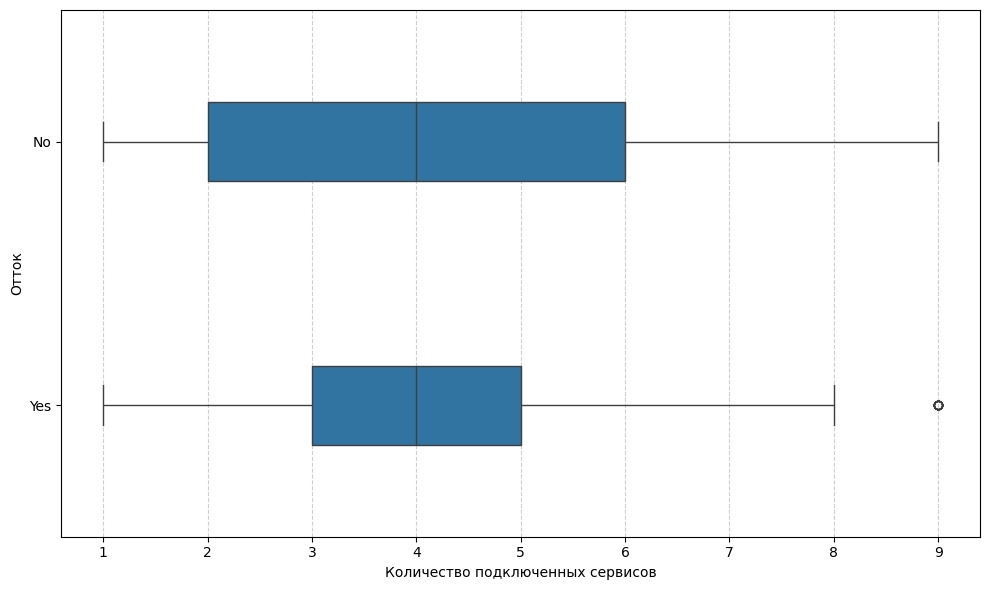

In [45]:
plt.figure(figsize=(10, 6), dpi=100)
sns.boxplot(data=df, x='ServicesCount', y='Churn', width=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlabel('Количество подключенных сервисов')
plt.ylabel('Отток')
plt.tight_layout();

Выводы по графику:
1) По Box Plot видно, что разброс у оставшихся (No) (от 2 до 6) больше, чем у ушедших (Yes) (от 3 до 5). Также группа Yes имеет максимум 8 услуг (и выбросы), а группа No имеет максимум 9.
2) Медиана количества подключенных услуг у ушедших и оставшихся клиентов идентична (=4).

### Выводы по гипотезе 5
1) Количество подключенных услуг не является сильным самостоятельным предиктором оттока.
2) Отток, вероятно, не связан с дефицитом функционала (т.е. "мне не хватало услуг"). Вместо этого, отток привязан к другим факторам (Contract, Partner), или к цене

Это все говорит о том, что, вероятно, количество подключенных услуг не сильно влияет на отток клиентов. Гипотеза опровергнута.

# Гипотеза 6
## Большие траты в месяц прямым образом могут повлиять на уход клиента, чем выше, тем больше шанс ухода.

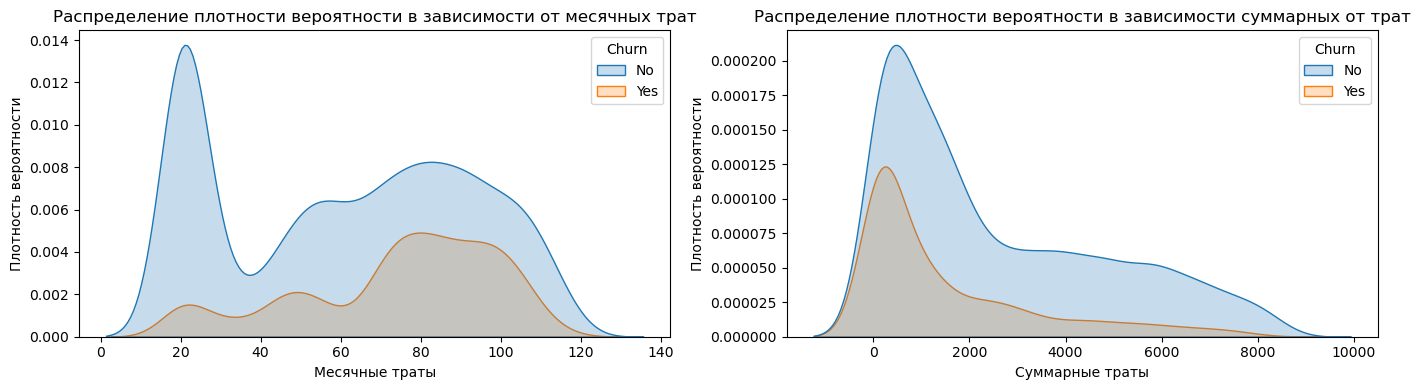

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, ax=axes[0])
axes[0].set_title('Распределение плотности вероятности в зависимости от месячных трат')
axes[0].set_xlabel('Месячные траты')
axes[0].set_ylabel('Плотность вероятности')
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, ax=axes[1]);
axes[1].set_title('Распределение плотности вероятности в зависимости суммарных от трат')
axes[1].set_xlabel('Суммарные траты')
axes[1].set_ylabel('Плотность вероятности')
plt.tight_layout();

In [47]:
df.sample(10)[['MonthlyCharges', 'TotalCharges']]

,MonthlyCharges,TotalCharges
57,108.45,7076.35
6549,56.25,56.25
4335,84.95,1443.65
2339,94.25,1973.75
2952,20.25,493.95
4792,106.25,6979.80
2963,25.60,917.15
3561,80.50,2088.80
5282,95.20,292.85
116,31.05,1126.35


In [48]:
df[['MonthlyCharges', 'TotalCharges']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


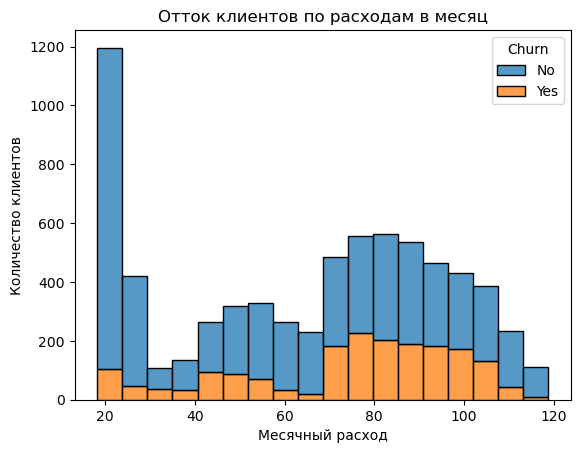

In [49]:
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack')
plt.title('Отток клиентов по расходам в месяц')
plt.xlabel('Месячный расход')
plt.ylabel('Количество клиентов');

Выводы по графику:
1) Группа клиентов, которая тратит примерно менее 70 единиц денежной валюты, намного реже уходит, те, кто тратит более 70 единиц, чаще подвергаются оттоку.
2) Лишь самые большие траты подвергаются маленькому оттоку, что может говорить о большой лояльности клиентов, которые могут себе позволить большие траты в месяц.

### Выводы по гипотезе 6
1) Выделяются 3 группы по расходам в месяц: ≈20 - ≈70 единиц - низкий уровень оттока, ≈70 - ≈105 единиц - высокий уровень оттока и ≈105 - ≈120 единиц - низкий уровень оттока.

Гипотеза о том, что высокие траты прямо увеличивают риск оттока, опровергается в самом высоком диапазоне, но подтверждается в средне-высоком диапазоне (≈70−≈105 ).

# Гипотеза 7
## Клиенты с безбумажным биллингом (PaperlessBilling = Yes) уходят реже, чем клиенты с бумажными счетами.

In [50]:
df['PaperlessBilling'].value_counts()

PaperlessBilling
1    4168
0    2864
Name: count, dtype: int64

In [51]:
paperless_billing_churn_pct = df.groupby(['PaperlessBilling', 'Churn'])['Churn']\
                                    .count().unstack().apply(lambda x: x/x.sum()*100, axis=1)

In [52]:
paperless_billing_churn_pct

Churn,No,Yes
PaperlessBilling,,
0,83.624302,16.375698
1,66.410749,33.589251


In [53]:
df_paperless_billing_long = paperless_billing_churn_pct.reset_index().melt(id_vars='PaperlessBilling', 
                                              value_vars=['No', 'Yes'],
                                              var_name='Churn',
                                              value_name='Percentage')

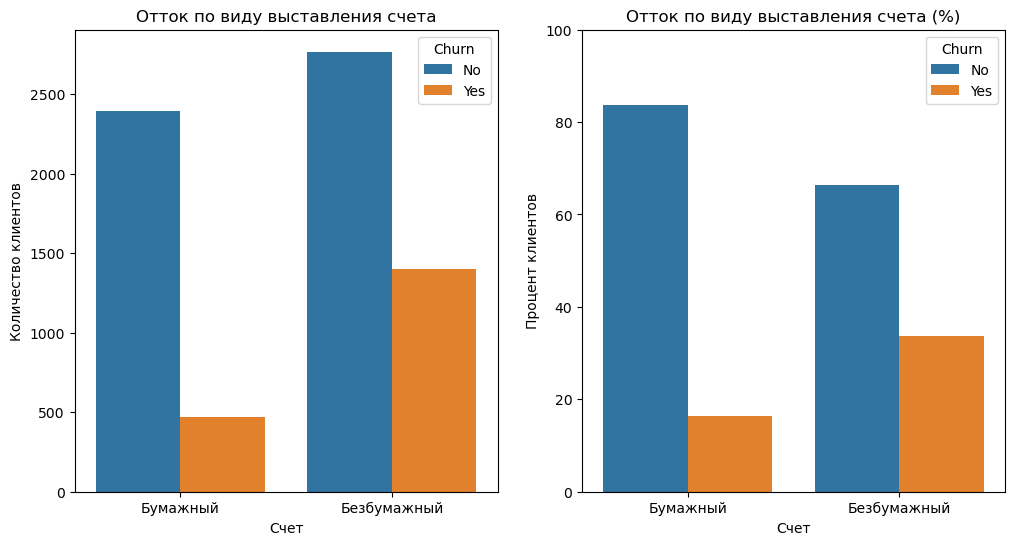

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=df, x='PaperlessBilling', hue='Churn', ax=axes[0])
axes[0].set_title('Отток по виду выставления счета')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xticks([0, 1], ['Бумажный', 'Безбумажный'])
axes[0].set_xlabel('Счет');

sns.barplot(data=df_paperless_billing_long, x='PaperlessBilling', y='Percentage', hue='Churn', ax=axes[1])
axes[1].set_xticks([0, 1], ['Бумажный', 'Безбумажный'])
axes[1].set_ylabel('Процент клиентов')
axes[1].set_xlabel('Счет')
axes[1].set_title('Отток по виду выставления счета (%)')
axes[1].set_ylim(0, 100);

Выводы по графику:
1) Бумажный счет удерживает ≈84% клиентов (≈16% - отток), тогда как безбумажный ≈66% (≈34% - отток), разница более чем в два раза по оттоку клиентов (35%/16%≈2.125 раза).

### Выводы по гипотезе 7
1) Клиенты с безбумажным биллингом имеют в два раза больший относительный риск оттока по сравнению с клиентами, получающими бумажные счета.

Гипотеза 7: "Клиенты, использующие безбумажный биллинг, чаще уходят" - Подтверждена.

# Гипотеза 8
## Клиенты с автоматической оплатой (Bank transfer или Credit card) уходят реже, чем клиенты с электронными или почтовыми чеками.

In [55]:
payment_order = df['PaymentMethod'].unique()
payment_order

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [56]:
df['PaymentMethod'].value_counts() / df['PaymentMethod'].count() * 100

PaymentMethod
Electronic check             33.631968
Mailed check                 22.810011
Bank transfer (automatic)    21.928328
Credit card (automatic)      21.629693
Name: count, dtype: float64

In [57]:
payment_method_pct =  df.groupby(['PaymentMethod', 'Churn'])['Churn'].count().unstack().apply(lambda x: x/x.sum()*100, axis=1)

In [58]:
payment_method_pct

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),83.268482,16.731518
Credit card (automatic),84.746877,15.253123
Electronic check,54.714588,45.285412
Mailed check,80.798005,19.201995


In [59]:
df_payment_method_long = payment_method_pct.reset_index().melt(id_vars='PaymentMethod', 
                                              value_vars=['No', 'Yes'],
                                              var_name='Churn',
                                              value_name='Percentage')

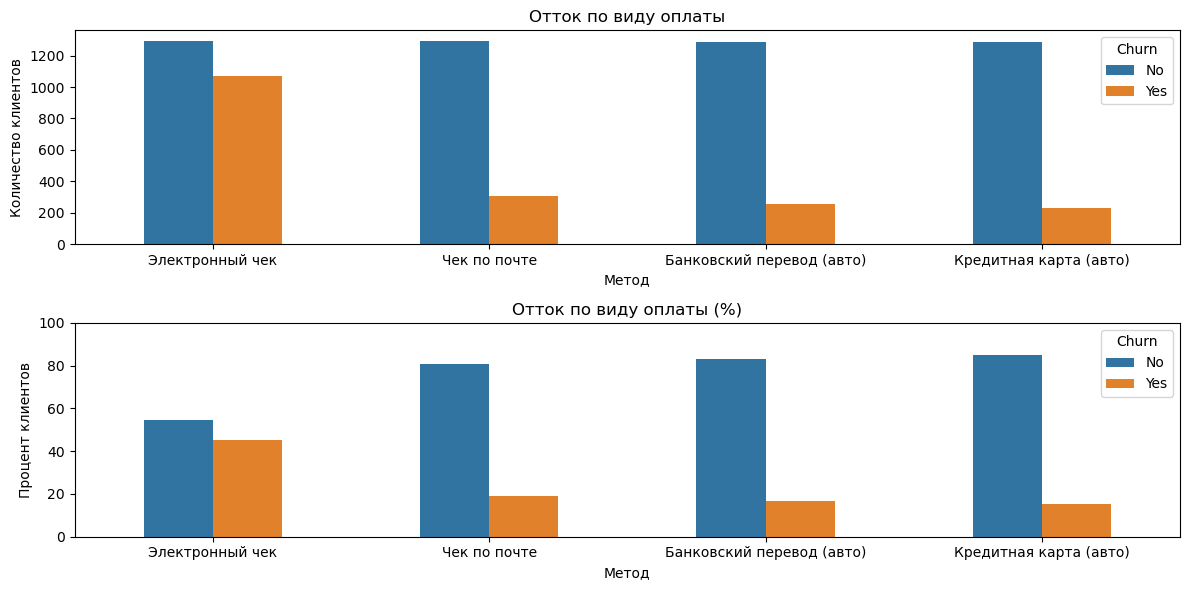

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.countplot(data=df, x='PaymentMethod', hue='Churn', ax=axes[0], width=0.5, order=payment_order)
axes[0].set_title('Отток по виду оплаты')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xticks([0, 1, 2, 3], ['Электронный чек', 'Чек по почте', 'Банковский перевод (авто)', 'Кредитная карта (авто)'])
axes[0].set_xlabel('Метод');

sns.barplot(data=df_payment_method_long, x='PaymentMethod', y='Percentage', hue='Churn', ax=axes[1], width=0.5, order=payment_order)
axes[1].set_xticks([0, 1, 2, 3], ['Электронный чек', 'Чек по почте', 'Банковский перевод (авто)', 'Кредитная карта (авто)'])
axes[1].set_ylabel('Процент клиентов')
axes[1].set_xlabel('Метод')
axes[1].set_title('Отток по виду оплаты (%)')
axes[1].set_ylim(0, 100)
plt.tight_layout()

Выводы по графику:
1) Только лишь электронный чек подвержен высокому оттоку клиентов (≈45%), остальные методы держат более низкий отток клиентов, примерно 15-19%.

## Выводы по гипотезе 8
1) Электронный чек является высоким фактором оттока клиентов (≈45% оттока на ≈55% удержания), тогда как остальные способы стабильно ниже держат процент оттока клиентов (≈15-19% на отток и ≈81-85% удержание)

Гипотеза 8: "Некоторые способы оплаты имеют значительно более высокий уровень оттока" - Подтверждена.

# Feature engineering 

## На основе проделанного EDA проведу конструирование новых признаков

1. Признак "Пользуется несколькими сервисами" - HasMultipleServices
2. Признак "Ценный клиент" - IsHighValueCustomer
3. Разделю клиентов на когорты по длительности пользования услугами - New, Medium, Long

In [61]:
df['HasMultipleServices'] = (df['ServicesCount'] > 1).astype(int)
df['IsHighValueCustomer'] = ((df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)) & 
                             (df['tenure'] > 12)).astype(int)

df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 20, 65, 72],
                          labels=['New', 'Medium', 'Long'])

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

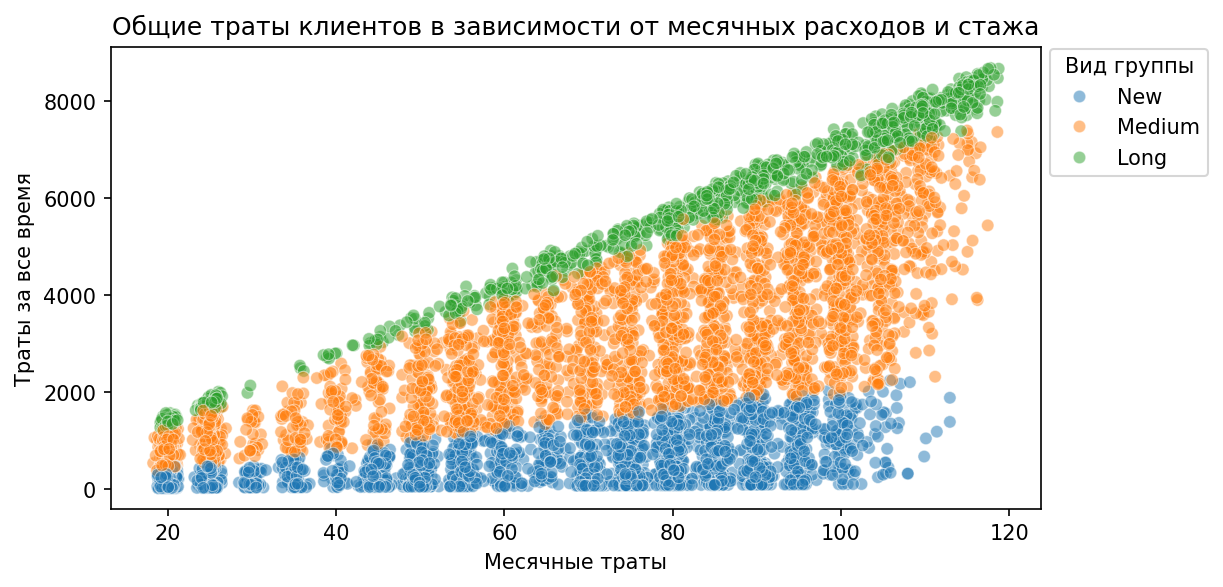

In [62]:
plt.figure(figsize=(8, 4), dpi=150)
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='TenureGroup', alpha=0.5);
plt.title('Общие траты клиентов в зависимости от месячных расходов и стажа')
plt.xlabel('Месячные траты')
plt.ylabel('Траты за все время')
plt.legend(loc=(1.01, 0.72), title='Вид группы');

Выводы из графика:
1. При одинаковых месячных тратах долгосрочные клиенты (Long) накапливают в 3–5 раз больше общей выручки, чем новые (New).

In [63]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [136]:
test_VIF = X[X.select_dtypes(include=['int64', 'float64', 'int32']).columns].copy()
test_VIF_const = sm.add_constant(test_VIF)

In [137]:
vif = pd.DataFrame()
vif["feature"] = test_VIF_const.columns
vif["VIF"] = [variance_inflation_factor(test_VIF_const.values, i) for i in range(test_VIF_const.shape[1])]
vif = vif.round(2)
vif

,feature,VIF
0,const,15.96
1,SeniorCitizen,1.13
2,Partner,1.46
3,Dependents,1.37
4,tenure,6.52
5,PaperlessBilling,1.17
6,MonthlyCharges,7.59
7,TotalCharges,12.83
8,ServicesCount,5.90
9,HasMultipleServices,2.40


Переменная TotalCharges имеет VIF = 12.84, что указывает на сильную мультиколлинеарность с MonthlyCharges и tenure (так как TotalCharges ≈ MonthlyCharges × tenure). Поскольку задача не требует интерпретации коэффициентов линейных моделей, TotalCharges оставлен в датасете для использования в ансамблевых моделях (Random Forest, AdaBoost).

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [65]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64', 'int32']).columns

In [66]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ]
)
cat_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ]
)

In [67]:
scoring = {
    'Accuracy': 'accuracy',
    'F1': 'f1',
    'Precision': 'precision',
    'Recall': 'recall',
    'ROC_AUC': 'roc_auc'
}

# Logistic Regression

## Logistic Regression with GridSearchCV

In [68]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=100000, class_weight='balanced'))
])
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(-3, 3, 15),
    'classifier__solver': ['saga', 'liblinear'],
}
lr_grid = GridSearchCV(estimator=lr_pipeline, param_grid=param_grid, n_jobs=-1, scoring=scoring, refit='F1')

In [69]:
lr_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'ServicesCount',
       'HasMultipleServices', 'IsHighValueCustomer'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignor...
       5.17947468e-02, 1.38949549e-01, 3.72759372e-01, 1.00000000e+00,
       2.68269580e+00, 7.19685673e+00, 1.93069773e+01, 5.17947468e+01,
       1.38949549e+02, 3.72759372e+02, 1.00000000e+03]),
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['saga', 'liblinear']},
             refit='F1',
             scoring={'Accuracy': 'accuracy', 'F1': 'f1',
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall'})

In [70]:
lr_grid.best_params_

{'classifier__C': 0.13894954943731375,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [71]:
lr_grid.best_score_

0.6379261940261213

In [72]:
lr_best_model = lr_grid.best_estimator_

In [73]:
lr_best_model.named_steps['classifier'].coef_

array([[ 0.09040783, -0.01744808, -0.05395581, -1.00747108,  0.15786357,
         0.22223119,  0.3268261 , -0.13081272, -0.01057761, -0.0308626 ,
         0.01184018, -0.27808395,  0.27713926,  0.2317117 ,  0.62521002,
        -0.10005644, -0.10005644, -0.37367246, -0.10005644, -0.09476475,
        -0.10005644, -0.0180812 , -0.10005644, -0.31079707, -0.10005644,
         0.23611632, -0.10005644,  0.20286948, -0.67287919, -1.34907211,
        -0.0915429 ,  0.34272897, -0.07395649, -0.28751936, -0.10842737]])

In [74]:
results = lr_grid.cv_results_
for metric in ['mean_test_F1', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_ROC_AUC', 'mean_test_Accuracy']:
    print(f"{metric}: {results[metric][lr_grid.best_index_]}")

mean_test_F1: 0.6379261940261213
mean_test_Recall: 0.7979322548028311
mean_test_Precision: 0.5315727562584078
mean_test_ROC_AUC: 0.845682972183293
mean_test_Accuracy: 0.7536375500315332


In [75]:
lr_grid_y_preds = lr_grid.predict(X_test)
print(classification_report(y_test,lr_grid_y_preds))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81       557
           1       0.42      0.76      0.54       147

    accuracy                           0.73       704
   macro avg       0.67      0.74      0.68       704
weighted avg       0.82      0.73      0.76       704



Класс '1' (Ушел):
- Recall (Полнота): 0.76 (Модель нашла 76% всех действительно ушедших клиентов).
- Precision (Точность): 0.42 (Из всех клиентов, которых модель пометила как "рискованных", только 42% действительно ушли).

Вывод: Модель настроена на высокий охват (высокий Recall), чтобы минимизировать пропущенные уходы, но ценой 42% ложных срабатываний.

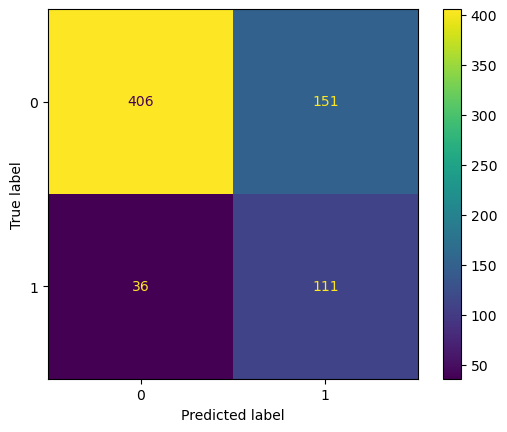

In [76]:
ConfusionMatrixDisplay.from_estimator(lr_grid, X_test, y_test);

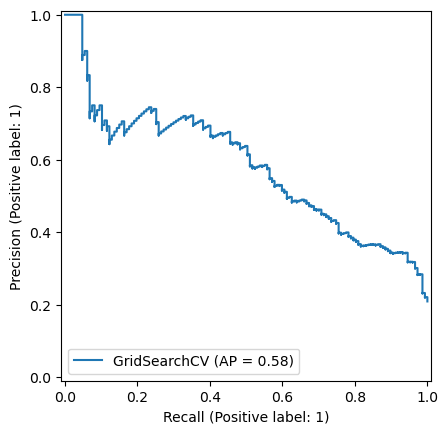

In [77]:
PrecisionRecallDisplay.from_estimator(lr_grid, X_test, y_test);

### Precision (точность модели):
- Показывает насколько точна модель, то есть какая доля клиентов, которых выделила модель (как уходящих), действительно ушла.
- Бизнес токлование: насколько надежны наши прогнозы (чем выше, тем меньше мы тратим деньги на удержание лояльных клиентов).
### Recall (полнота модели):
- Показывает насколько фактически модель права, то есть какую долю реально ушедших клиентов модель смогла найти.
- Бизнес толкование: сколько потенциальных потерь мы смогли предотвратить (чем выше, тем больше ушедших мы поймали).

Разбор графика:
1. Начало (Recall 0.0-0.45): на этом промежутке точность (Precision) высокая (осколо 0.7-0.9).
- Интерпретация: если выбрать самых очевидных уходящих клиентов (до 25% от выборки), то прогнозы будут очень надежными (практически не будет ошибок).
- Бизнес-инсайт: если бюджет ограниченный, то можно настроить порог на данном промежутке, чтобы тратить деньги только на самые очевидные потери.
2. Средняя часть (Recall 0.45-0.6): кривая постепенно опускается. чтобы поймать больше ушедших клиентов (45-60% от всех), нужно будет пожертвовать точностью в районе 0.6-0.7.
- Интерпретация: модель успешно находит почти половину или чуть больше всех клиентов, которые реально ушли.
- Бизнес-инсайт: зона разумного компромисса.
3. Конец (Recall 0.6-1.0): точность (Precision) резко падает, то есть половина прогнозов будет ошибочной.
- Интерпетация: если оставить точность низкой, но при этом полнота (Recall) будет в районе 0.7-0.8, то модель сможет находить практически всех уходящих клиентов, но к этой групее добавятся и ложные предсказания (False Positives), то есть те, кто не собирался уходить.
- Бизнес-инсайт: если бюджет позволяет, то можно выбрать стратегию высокой полноты (Recall) и более низкой точности (Precision в разумных количествах), чтобы найти как можно больше уходящих клиентов.

---

- Цель: Экономия - выбрать высокий порог (высокая Точность, низкая Полнота).
- Цель: Предотвращение потерь - выбрать низкий порог (низкая Точность, высокая Полнота).

# K-nearest neighbors

## K-nearest neighbors with GridSearchCV

In [78]:
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])
param_grid = {
    'classifier__n_neighbors': range(1, 30),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}
knn_grid = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid, n_jobs=-1, scoring=scoring, refit='F1')

In [79]:
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'ServicesCount',
       'HasMultipleServices', 'IsHighValueCustomer'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignor...
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'TenureGroup'],
      dtype='object'))])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': range(1, 30),
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             refit='F1',
             scoring={'Accuracy': 'accuracy', 'F1': 'f1',
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall'})

In [80]:
knn_grid.best_params_

{'classifier__n_neighbors': 27,
 'classifier__p': 1,
 'classifier__weights': 'uniform'}

In [81]:
knn_grid.best_score_

0.6016610741054071

In [82]:
results = knn_grid.cv_results_
for metric in ['mean_test_F1', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_ROC_AUC', 'mean_test_Accuracy']:
    print(f"{metric}: {results[metric][knn_grid.best_index_]}")

mean_test_F1: 0.6016610741054071
mean_test_Recall: 0.5772463768115942
mean_test_Precision: 0.6286492008986228
mean_test_ROC_AUC: 0.8325949152499661
mean_test_Accuracy: 0.7921955179239333


In [83]:
knn_grid_y_preds = knn_grid.predict(X_test)

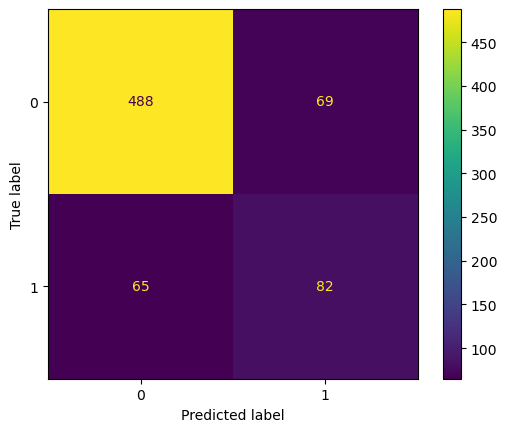

In [84]:
ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test);

In [85]:
print(classification_report(y_test, knn_grid_y_preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       557
           1       0.54      0.56      0.55       147

    accuracy                           0.81       704
   macro avg       0.71      0.72      0.71       704
weighted avg       0.81      0.81      0.81       704



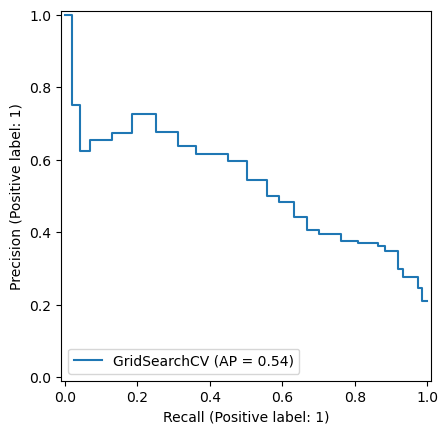

In [86]:
PrecisionRecallDisplay.from_estimator(knn_grid, X_test, y_test);

# Support Vector Machines (SVM)

## SVM with GridSearchCV

In [87]:
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced'))
])
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 0.5, 1],
    'classifier__gamma': ['auto', 'scale']
}
svm_grid = GridSearchCV(estimator=svm_pipeline, param_grid=param_grid, n_jobs=-1, scoring=scoring, refit='F1')

In [88]:
svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'ServicesCount',
       'HasMultipleServices', 'IsHighValueCustomer'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignor...
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'TenureGroup'],
      dtype='object'))])),
                                       ('classifier',
                                        SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 0.5, 1],
                         'classifier__gamma': ['auto', 'scale']},
             refit='F1',
             scoring={'Accuracy': 'accuracy', 'F1': 'f1',
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall'})

In [89]:
svm_grid.best_params_

{'classifier__C': 0.5, 'classifier__gamma': 'scale'}

In [90]:
svm_grid.best_score_

0.6336820847575219

In [91]:
results = svm_grid.cv_results_
for metric in ['mean_test_F1', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_ROC_AUC', 'mean_test_Accuracy']:
    print(f"{metric}: {results[metric][svm_grid.best_index_]}")

mean_test_F1: 0.6336820847575219
mean_test_Recall: 0.7932726659925851
mean_test_Precision: 0.5276576721760712
mean_test_ROC_AUC: 0.8337466074763625
mean_test_Accuracy: 0.750475994230373


In [92]:
svm_grid_y_preds = svm_grid.predict(X_test)

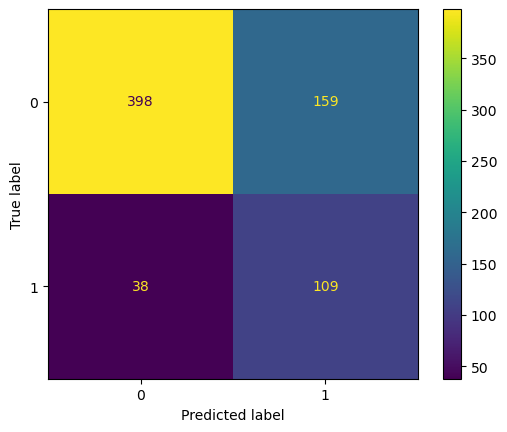

In [93]:
ConfusionMatrixDisplay.from_estimator(svm_grid, X_test, y_test);

In [94]:
print(classification_report(y_test, svm_grid_y_preds))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       557
           1       0.41      0.74      0.53       147

    accuracy                           0.72       704
   macro avg       0.66      0.73      0.66       704
weighted avg       0.81      0.72      0.74       704



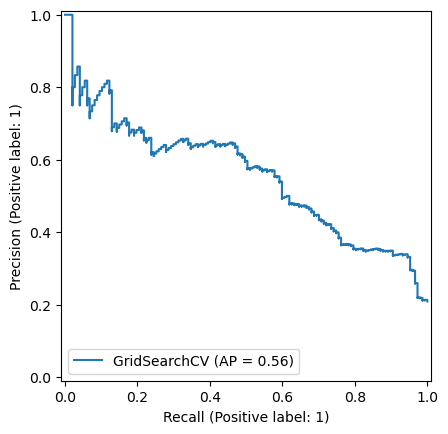

In [95]:
PrecisionRecallDisplay.from_estimator(svm_grid, X_test, y_test);

# Decisions trees

## Decisions trees with GridSearchCV 

In [96]:
tree_pipeline = Pipeline([
    ('cat_preprocessor', cat_preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced'))
])
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20],
    'classifier__max_leaf_nodes': [10, 20, 30, 50, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 5, 10],
}
tree_grid = GridSearchCV(estimator=tree_pipeline, param_grid=param_grid, n_jobs=-1, scoring=scoring, refit='F1')

In [97]:
tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cat_preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'TenureGrou...
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, 7, 10, 15, 20],
                         'classifier__max_leaf_nodes': [10, 20, 30, 50, None],
                         'classifier__min_samples_leaf': [1, 2, 4, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10, 20]},
             refit='F1',
             scoring={'Accuracy': 'accuracy', 'F1': 'f1',
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall'})

In [98]:
tree_grid.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 30,
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 2}

In [99]:
tree_grid.best_score_

0.6240749866140135

In [100]:
results = tree_grid.cv_results_
for metric in ['mean_test_F1', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_ROC_AUC', 'mean_test_Accuracy']:
    print(f"{metric}: {results[metric][tree_grid.best_index_]}")

mean_test_F1: 0.6240749866140135
mean_test_Recall: 0.7758358611391978
mean_test_Precision: 0.5225918670914018
mean_test_ROC_AUC: 0.8289338239566444
mean_test_Accuracy: 0.7451072438791375


In [101]:
tree_grid_y_preds = tree_grid.predict(X_test)

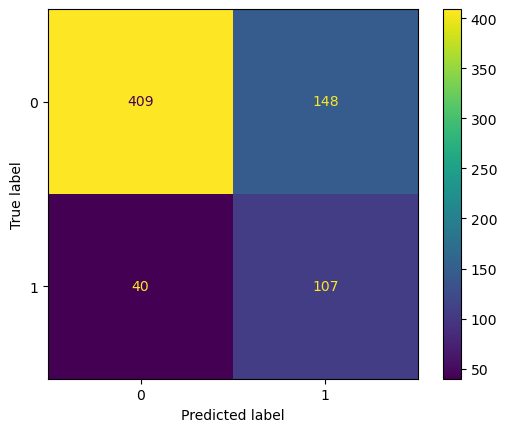

In [102]:
ConfusionMatrixDisplay.from_estimator(tree_grid, X_test, y_test);

In [103]:
print(classification_report(y_test, tree_grid_y_preds))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       557
           1       0.42      0.73      0.53       147

    accuracy                           0.73       704
   macro avg       0.67      0.73      0.67       704
weighted avg       0.81      0.73      0.75       704



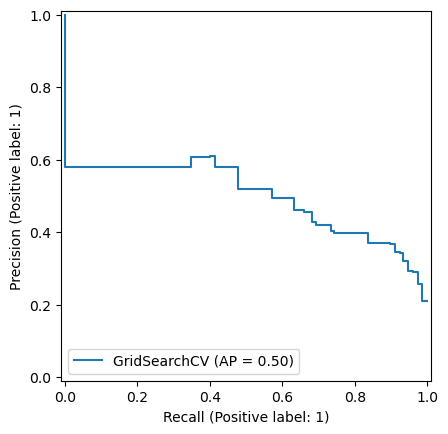

In [104]:
PrecisionRecallDisplay.from_estimator(tree_grid, X_test, y_test);

# Random forests

## Random forests with GridSearchCV

In [105]:
rfc_pipeline = Pipeline([
    ('preprocessor', cat_preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=100))
])
param_grid = {
    'classifier__max_features': ['sqrt', 'log2'],
    #'classifier__n_estimators': [64, 100, 128],
    'classifier__max_depth': [3, 5, 7, 10, 15, 20],
    'classifier__max_leaf_nodes': [10, 20, 30, 50, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 5, 10],
}
rfc_grid = GridSearchCV(estimator=rfc_pipeline, param_grid=param_grid, n_jobs=-1, scoring=scoring, refit='F1')

In [106]:
rfc_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'TenureGroup'],...
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, 7, 10, 15, 20],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__max_leaf_nodes': [10, 20, 30, 50, None],
                         'classifier__min_samples_leaf': [1, 2, 4, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10, 20]},
             refit='F1',
             scoring={'Accuracy': 'accuracy', 'F1': 'f1',
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall'})

In [107]:
rfc_grid.best_params_

{'classifier__max_depth': 15,
 'classifier__max_features': 'log2',
 'classifier__max_leaf_nodes': 50,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 5}

In [108]:
rfc_grid.best_score_

0.6328655740461816

In [109]:
results = rfc_grid.cv_results_
for metric in ['mean_test_F1', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_ROC_AUC', 'mean_test_Accuracy']:
    print(f"{metric}: {results[metric][rfc_grid.best_index_]}")

mean_test_F1: 0.6328655740461816
mean_test_Recall: 0.7909470845972362
mean_test_Precision: 0.5275279892655079
mean_test_ROC_AUC: 0.8363865138179127
mean_test_Accuracy: 0.7501611624174986


In [110]:
rfc_grid_y_preds = rfc_grid.predict(X_test)

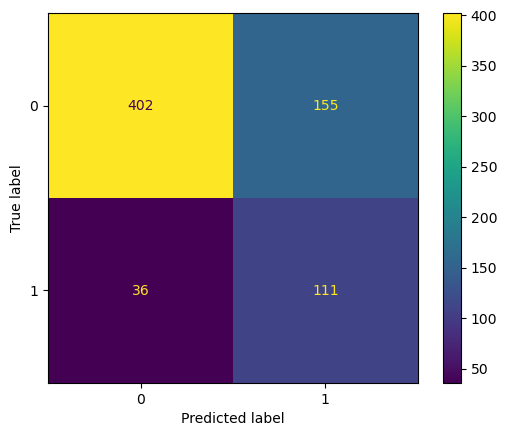

In [111]:
ConfusionMatrixDisplay.from_estimator(rfc_grid, X_test, y_test);

In [112]:
print(classification_report(y_test, rfc_grid_y_preds))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       557
           1       0.42      0.76      0.54       147

    accuracy                           0.73       704
   macro avg       0.67      0.74      0.67       704
weighted avg       0.81      0.73      0.75       704



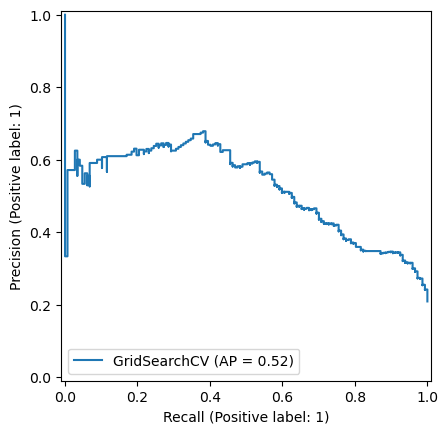

In [113]:
PrecisionRecallDisplay.from_estimator(rfc_grid, X_test, y_test);

# AdaBoost

## AdaBoost with GridSearchCV

In [114]:
ab_pipeline = Pipeline([
    ('preprocessor', cat_preprocessor),
    ('classifier', AdaBoostClassifier(algorithm='SAMME'))
])
param_grid = {
    'classifier__learning_rate': [0.3, 0.6, 1],
    'classifier__n_estimators': [50, 100, 150, 200]
}
ab_grid = GridSearchCV(estimator=ab_pipeline, param_grid=param_grid, n_jobs=-1, scoring=scoring, refit='F1')

In [115]:
ab_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'TenureGroup'],
      dtype='object'))])),
                                       ('classifier',
                                        AdaBoostClassifier(algorithm='SAMME'))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.3, 0.6, 1],
                         'classifier__n_estimators': [50, 100, 150, 200]},
             refit='F1',
             scoring={'Accuracy': 'accuracy', 'F1': 'f1',
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall'})

In [116]:
ab_grid.best_params_

{'classifier__learning_rate': 1, 'classifier__n_estimators': 200}

In [117]:
ab_grid.best_score_

0.5846074214402961

In [118]:
results = ab_grid.cv_results_
for metric in ['mean_test_F1', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_ROC_AUC', 'mean_test_Accuracy']:
    print(f"{metric}: {results[metric][ab_grid.best_index_]}")

mean_test_F1: 0.5846074214402961
mean_test_Recall: 0.5296090326929559
mean_test_Precision: 0.6530212895092113
mean_test_ROC_AUC: 0.8390364493466116
mean_test_Accuracy: 0.795196348400552


In [119]:
ab_grid_y_preds = ab_grid.predict(X_test)

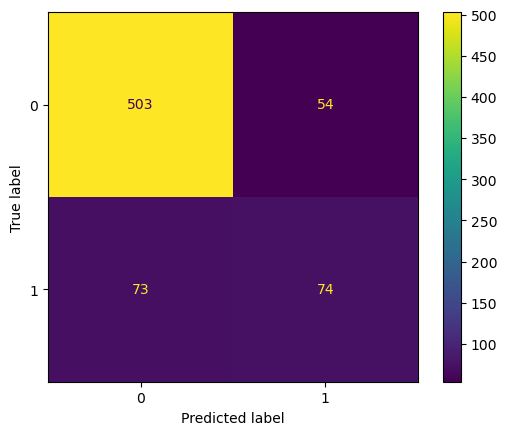

In [120]:
ConfusionMatrixDisplay.from_estimator(ab_grid, X_test, y_test);

In [121]:
print(classification_report(y_test, ab_grid_y_preds))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       557
           1       0.58      0.50      0.54       147

    accuracy                           0.82       704
   macro avg       0.73      0.70      0.71       704
weighted avg       0.81      0.82      0.81       704



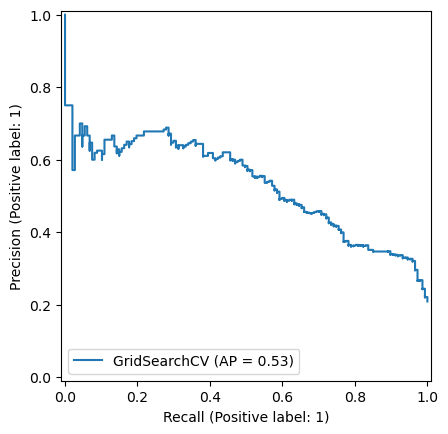

In [122]:
PrecisionRecallDisplay.from_estimator(ab_grid, X_test, y_test);

# Анализ результатов моделей

Сценарий 1 - Снижение оттока клиентов:
- Если основная цель бизнеса - удержать как можно больше клиентов, даже ценой появления ложных срабатываний (то есть система может ошибочно пометить некоторых лояльных клиентов как "уходящих"), то следует выбрать модели, у которых высокий показатель recall для класса '1' (ушедших клиентов).
Высокий recall (> 0.6) означает, что модель хорошо распознаёт тех, кто действительно склонен уйти, что позволит вовремя применять меры удержания.
    - Пример: модели Logistic Regression, SVM, Decision Tree, Random Forest - показали хороший recall, что делает их подходящими для сценариев, где важно минимизировать количество «упущенных» уходящих клиентов.
 
Сценарий 2 - Формирование лояльной аудитории (удержание уже имеющейся):
- Если бизнесу важно сосредоточиться на удержании текущих лояльных клиентов и не тратить ресурсы на неверно определённых "уходящих",
предпочтительнее использовать модели с высоким precision для класса '1'.
Это снизит количество ложных тревог и позволит точнее определять действительно «проблемных» клиентов.
    - Пример: KNN и AdaBoost показали хорошие precision, recall и accuracy для сценария формирования лояльной аудитории.

# Итоги проекта

## Контекст задачи 

Для создания этого проекта был взят самый популярный датасет на Kaggle - [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn), который предоставляет отличную возможность тестировать идеи, изучать анализ данных и машинное обучение, а также практиковаться в очистке данных и feature engineering.

Данная работа демонстрирует полный цикл построение модели машинного обучения - от постановки гипотез и разведочного анализа до обучения и оценки нескольких алгоритмов. Основная цель проекта заключалась в предсказании факта ухода клиента (Churn) на основе его характеристик и поведения.

В рамках проекта были проведены:
1. Первичный анализ и формулировка гипотез о возможных причинах оттока клиентов
2. Детальный EDA с визуализацией зависимостей
3. Создание новых признаков и очистка данных
4. Обучение и сравнение нескольких моделей (Logistic Regression, KNN, SVM, Decision Tree, Random Forest, AdaBoost)
5. Анализ полученных метрик и определение наиболее эффективного подхода.

Проект позволил закрепить понимание полного ML-пайплайна и получить практический опыт работы с реальными данными.

## Подход и процесс

1. Перед проведением EDA был выполнен первичный анализ данных для выявления базовых закономерностей и оценки баланса классов.
2. Этап EDA проводился на основе заранее выдвинутых гипотез, цель которых - подтвердить или опровергнуть возможные причины оттока клиентов. В ходе анализа подтвердились 7 гипотез, одна была опровергнута.
3. На основании полученных результатов и выводов из EDA были добавлены три новых признака, потенциально способных повысить качество моделей.
4. После завершения анализа и feature engineering были созданы препроцессоры для автоматической обработки данных в пайплайнах, а также базовые модели. Подбор гиперпараметров осуществлялся с помощью метода GridSearchCV, что позволило найти оптимальные комбинации параметров и повысить точность предсказаний. Для каждой модели были рассчитаны метрики (precision, recall, accuracy, f1-score), построена матрица ошибок и график зависимости precision–recall. Оценка производилась на финальном тестовом наборе данных, который не участвовал в обучении.
5. На основе анализа метрик были сделаны выводы для двух стратегических направлений:
    1. Сосредоточить усилия на клиентах с высоким риском оттока.
    2. Удерживать «старых» клиентов, формируя более лояльную аудиторию.

## Результаты моделей

Среди протестированных моделей лучшие результаты показали KNN и AdaBoost, обе продемонстрировали accuracy около 0.81-0.82.
KNN показал наиболее сбалансированные значения precision и recall (0.88/0.88), в то время как AdaBoost обеспечил чуть более высокую точность на классе 0 (клиенты, которые остаются), но слабее выделял клиентов, склонных к уходу (recall = 0.50).

Классические алгоритмы - Logistic Regression, SVM, Decision Tree и Random Forest - показали схожие результаты (accuracy ≈ 0.72-0.74). При этом все модели демонстрируют одну закономерность: они лучше определяют клиентов, которые не уходят, и хуже распознают уходящих. Это объясняется дисбалансом классов.

В целом, KNN и AdaBoost можно считать оптимальными решениями для данной задачи, где важно сохранить баланс между точностью и полнотой предсказаний.

## Выводы

В результате проделанной работы удалось построить несколько моделей для прогнозирования оттока клиентов на основе данных компании. Наилучшие результаты по точности и сбалансированности метрик показали модели KNN и AdaBoost. Разработанное решение может быть использовано для раннего выявления клиентов, склонных к уходу, что позволит компании своевременно предпринимать меры по их удержанию и снижать общий уровень оттока.